In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras import backend as K
import gc

2025-11-25 15:50:28.305713: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-25 15:50:28.313083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764066028.322575  196800 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764066028.325808  196800 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764066028.333436  196800 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# RealWaste Dataset


## Loading the Dataset
This cell loads the **RealWaste** dataset, which contains images of waste items categorized into multiple classes such as plastic, paper, metal, glass, and organic materials.  
The TensorFlow utility `image_dataset_from_directory()` automatically reads the images from the specified directory, resizes them to **256×256**, groups them into batches of **32**, and shuffles them for training.  
This prepares the dataset for use in model training and evaluation. 

In [3]:
#load the dataset
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory=r'../RealWaste',
    batch_size=32,
    image_size=(256,256),     #resizing
    shuffle=True,
    seed=123)

Found 4752 files belonging to 9 classes.


I0000 00:00:1764066072.054235  196800 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1204 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [4]:
#check which classes are in the dataset
dataset.class_names

['Cardboard',
 'Food Organics',
 'Glass',
 'Metal',
 'Miscellaneous Trash',
 'Paper',
 'Plastic',
 'Textile Trash',
 'Vegetation']

## Training dataset

In [6]:
train_dataset=dataset.take(104) #take first 139 batches as traning
remaining=dataset.skip(104) #take the remaning batches

print(f"Percentage of traning set {round(((len(train_dataset)/len(dataset))*100))} %")
print(f"Percentage of test set {round(((len(remaining)/len(dataset))*100))} %")

Percentage of traning set 70 %
Percentage of test set 30 %


## Test Dataset

In [8]:
test_dataset=remaining.take(22)
cv_dataset=remaining.skip(22)
print(f"Percentage of traning set {round(((len(test_dataset)/len(dataset))*100))} %")
print(f"Percentage of test set {round(((len(cv_dataset)/len(dataset))*100))} %")

Percentage of traning set 15 %
Percentage of test set 15 %


## Save the splits

In [9]:
test_dataset.save('saved_datasets/test_dataset')
train_dataset.save('saved_datasets/train_dataset')
cv_dataset.save('saved_datasets/cv_dataset')

## Load The saved dataset

In [10]:
train_dataset = tf.data.Dataset.load('saved_datasets/train_dataset')
cv_dataset = tf.data.Dataset.load('saved_datasets/cv_dataset')
test_dataset = tf.data.Dataset.load('saved_datasets/test_dataset')

In [11]:
#to use for prediction in the later phase
class_names = ['Cardboard', 'Food Organics', 'Glass', 'Metal','Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']

## to visualize the images

(32, 256, 256, 3)
(32,)


2025-11-25 15:52:17.448671: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


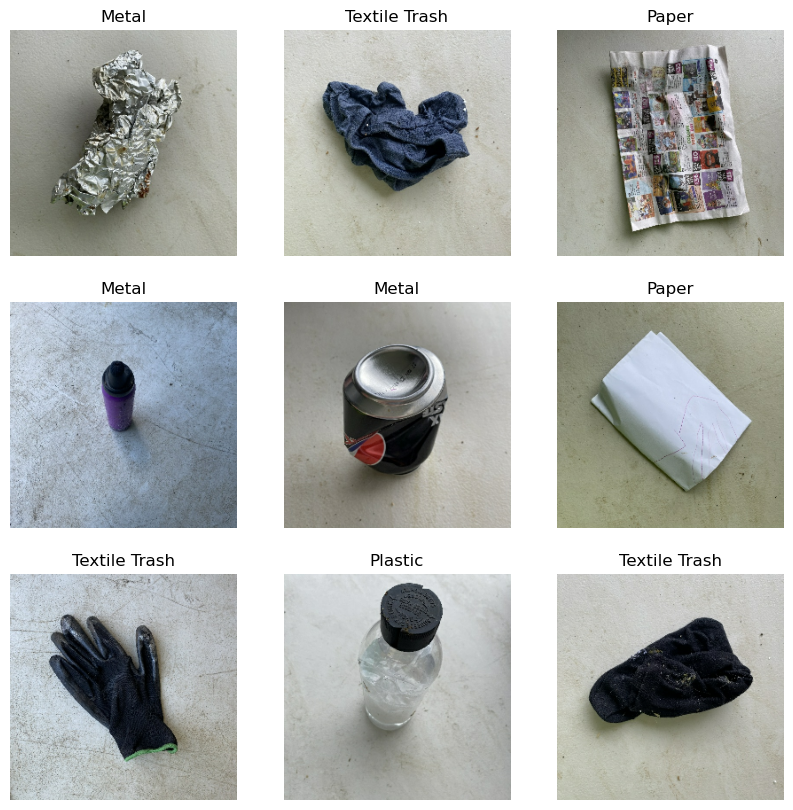

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):

  print(images.shape)
  print(labels.shape)

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
len(train_dataset)

104

## A function to count the images class-wise for each split

In [14]:
def class_counts(dataset, num_classes):
    counts = np.zeros(num_classes, dtype=int)
    for _, labels in dataset.unbatch():      
        if len(labels.shape) == 0:           
            counts[labels.numpy()] += 1
        else:                                
            counts[np.argmax(labels.numpy())] += 1
    return counts

In [ ]:
train_counts = class_counts(train_dataset, 9)
train_counts # how many images are there for each class
#class_names = ['Cardboard', 'Food Organics', 'Glass', 'Metal','Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']

array([322, 293, 317, 537, 353, 365, 646, 226, 301])

In [ ]:
test_counts = class_counts(test_dataset, 9)
test_counts # how many images are there for each class
#class_names = ['Cardboard', 'Food Organics', 'Glass', 'Metal','Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']

array([ 61,  68,  58, 132,  79,  59, 137,  47,  63])

In [ ]:
cv_counts = class_counts(cv_dataset, 9)
cv_counts # how many images are there for each class
#class_names = ['Cardboard', 'Food Organics', 'Glass', 'Metal','Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']

array([ 63,  52,  51, 125,  69,  70, 146,  50,  62])

## Data Preprocessing, Augmentation, and Callbacks

- **Rescaling & Resizing:**  
  The `rescale_resize` Sequential model normalizes pixel values to the `[0,1]` range and resizes all images to **128×128** to ensure uniform input dimensions.

- **Data Augmentation:**  
  The `data_augmentation` Sequential model introduces random transformations such as horizontal flips, rotations, zooms, and translations to improve the model’s generalization by simulating real-world variations in waste images.

- **Training Callbacks:**  
  - `ReduceLROnPlateau`: Automatically reduces the learning rate when validation loss stops improving, helping finer convergence.  
  - `EarlyStopping`: Stops training early if validation loss stagnates for several epochs, restoring the best model weights to prevent overfitting.


In [16]:
from keras import Sequential
from keras.layers import Resizing, Rescaling, RandomRotation, RandomFlip , Dropout , RandomZoom , RandomTranslation , BatchNormalization
from keras.callbacks import ReduceLROnPlateau ,EarlyStopping

rescale_resize=Sequential([
    Rescaling(1.0/255),
    Resizing(128,128)
])

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.10),      
    RandomZoom(0.10),         
    RandomTranslation(0.10, 0.10), 
])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5, 
    restore_best_weights=True
)

# CNN Model Architecture (`AdamW(learning_rate=0.001,weight_decay=0.0001)`)

In [19]:
from keras import layers
model = Sequential([
    rescale_resize,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)),

    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    Dropout(0.4),
    
    layers.Dense(256, activation='relu'),
    
    layers.Dense(9, activation='softmax'),
])

In [20]:
from keras.optimizers import Adam,Nadam,AdamW
from keras.losses import SparseCategoricalCrossentropy

optimizer=AdamW(learning_rate=0.001,weight_decay=0.0001)

model.compile(optimizer=optimizer,
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [21]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=cv_dataset,
    callbacks=[reduce_lr, early_stop],
)

Epoch 1/20


I0000 00:00:1764066247.001709  196872 cuda_dnn.cc:529] Loaded cuDNN version 91002


104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.2197 - loss: 2.1061 - val_accuracy: 0.2625 - val_loss: 1.9658 - learning_rate: 0.0010
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.3122 - loss: 1.8777 - val_accuracy: 0.3292 - val_loss: 1.8154 - learning_rate: 0.0010
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.3705 - loss: 1.7262 - val_accuracy: 0.4375 - val_loss: 1.5761 - learning_rate: 0.0010
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.4261 - loss: 1.5929 - val_accuracy: 0.4403 - val_loss: 1.5484 - learning_rate: 0.0010
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.4678 - loss: 1.4722 - val_accuracy: 0.4972 - val_loss: 1.4026 - learning_rate: 0.0010
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5045 - loss: 1.3813 - val_accuracy: 0.4847 - val_loss: 1.4081 - learning_rate: 0.0010
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5162 - loss: 1.3428 - val

In [22]:
scores=model.evaluate(test_dataset)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6804 - loss: 0.9214


## Plot the results of traning the model

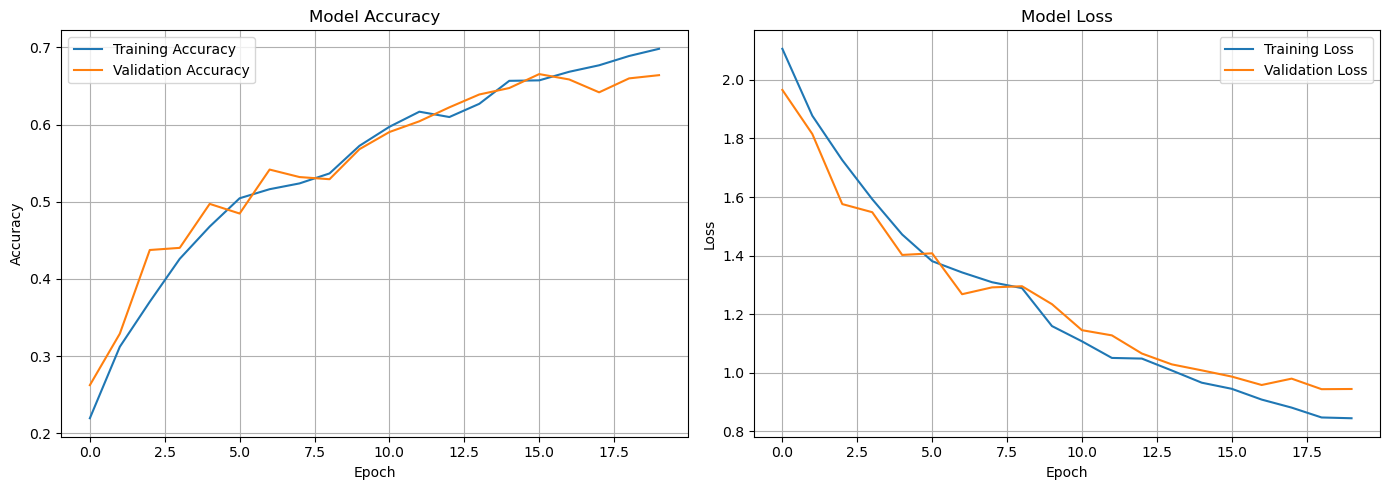


--------------------------------------------------
BASELINE MODEL PERFORMANCE
Final Training Accuracy: 0.6980
Final Validation Accuracy: 0.6639
Final Training Loss: 0.8451
Final Validation Loss: 0.9450
--------------------------------------------------


In [23]:
# Plot Results
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Final Performance
print("\n" + "-"*50)
print("BASELINE MODEL PERFORMANCE")
print("="*50)
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print("-"*50)

## Confusion Matrix Generation
This cell compares the model’s predicted classes with the actual labels from a sample batch of the `test_dataset`using **confusion matrix**.  

2025-11-25 15:56:11.360805: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


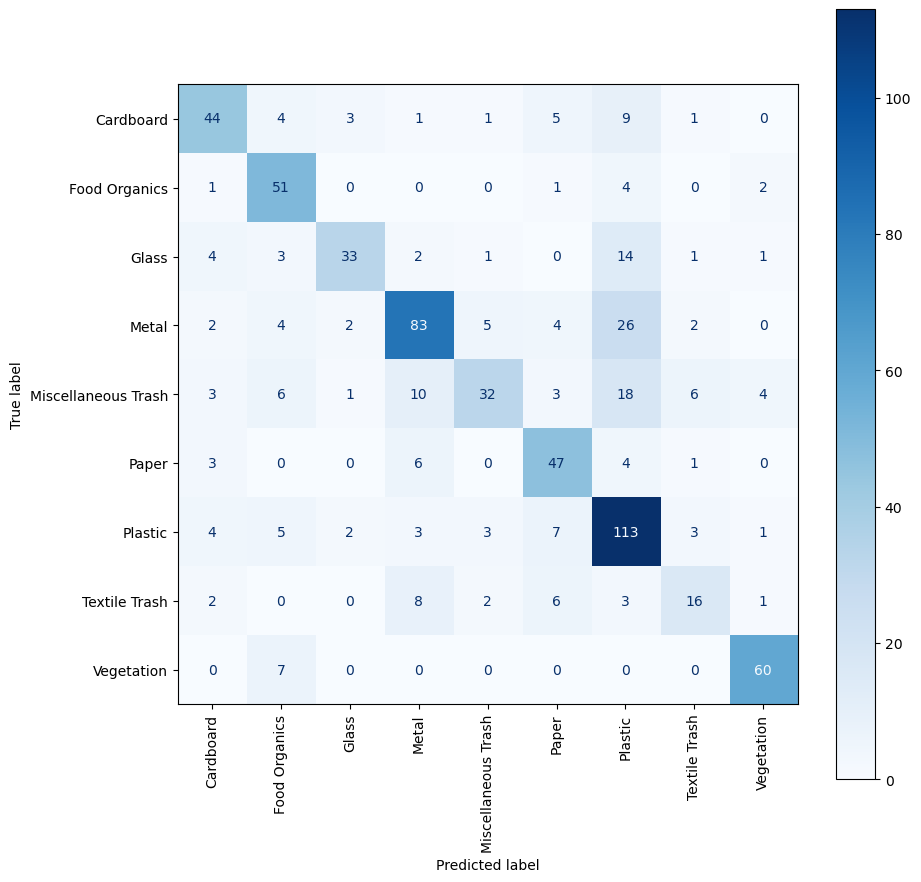

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

num_classes = len(class_names) 

y_true = []
y_pred = []

# collect predictions for the entire test set
for imgs, labels in test_dataset:
    preds = model.predict(imgs, verbose=0)
    y_true.append(labels.numpy())
    y_pred.append(np.argmax(preds, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# build confusion matrix with all 9 classes
conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

# plot
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format="d")
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=10)
plt.show()


### Performance Metrics Calculation
This cell computes key **classification performance metrics** for the model on the RealWaste dataset:

- **Precision:** Measures how many of the predicted positive samples are actually correct.  
- **Recall:** Measures how many of the actual positive samples were correctly identified.  
- **F1 Score:** Harmonic mean of precision and recall, providing a balanced metric between the two.  


In [25]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = []
y_pred = []

for imgs, labels in test_dataset:
    preds = model.predict(imgs, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision =", precision)
print("Recall =", recall)
print("F1 Score =", f1)


Precision = 0.6934574727996533
Recall = 0.6803977272727273
F1 Score = 0.672841012196015


# CNN Model Architecture (`SGD(learning_rate=0.001)`)

In [51]:
from keras import Sequential
from keras.layers import Resizing, Rescaling, RandomRotation, RandomFlip , Dropout , RandomZoom , RandomTranslation , BatchNormalization
from keras.callbacks import ReduceLROnPlateau ,EarlyStopping

rescale_resize=Sequential([
    Rescaling(1.0/255),
    Resizing(128,128)
])

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.10),      
    RandomZoom(0.10),         
    RandomTranslation(0.10, 0.10), 
])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5, 
    restore_best_weights=True
)

In [52]:
from keras import layers
model2 = Sequential([
    rescale_resize,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)),

    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    Dropout(0.4),
    
    layers.Dense(256, activation='relu'),
    
    layers.Dense(9, activation='softmax'),
])

/home/himan/Desktop/pattern project/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
from keras.optimizers import SGD

model2.compile(optimizer=SGD(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [54]:
history = model2.fit(
    train_dataset,
    epochs=20,
    validation_data=cv_dataset,
    callbacks=[reduce_lr, early_stop],
)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1653 - loss: 2.1852 - val_accuracy: 0.2125 - val_loss: 2.1695 - learning_rate: 0.0010
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1752 - loss: 2.1716 - val_accuracy: 0.1986 - val_loss: 2.1509 - learning_rate: 0.0010
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1896 - loss: 2.1583 - val_accuracy: 0.1986 - val_loss: 2.1393 - learning_rate: 0.0010
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1917 - loss: 2.1512 - val_accuracy: 0.1986 - val_loss: 2.1350 - learning_rate: 0.0010
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1941 - loss: 2.1495 - val_accuracy: 0.1986 - val_loss: 2.1329 - learning_rate: 0.0010
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1935 - loss: 2.1456 - val_accuracy: 0.1986 - val_loss: 2.1316 - learning_rate: 0.0010
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1944 - loss: 2.

In [55]:
scores=model2.evaluate(test_dataset)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2159 - loss: 2.0384


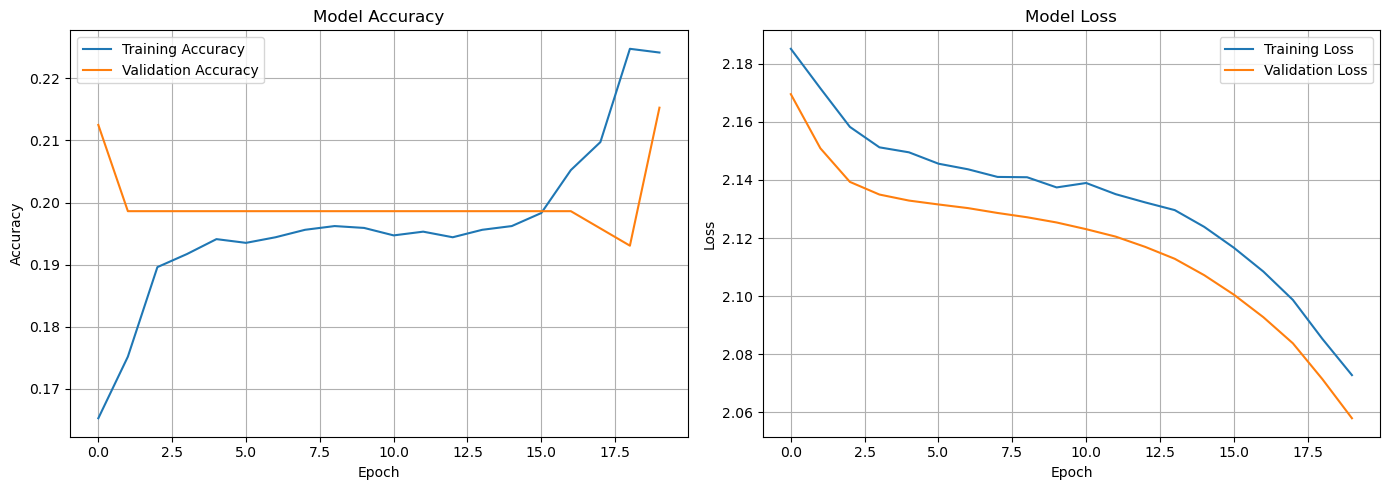


--------------------------------------------------
BASELINE MODEL PERFORMANCE
Final Training Accuracy: 0.2242
Final Validation Accuracy: 0.2153
Final Training Loss: 2.0728
Final Validation Loss: 2.0580
--------------------------------------------------


In [56]:
# Plot Results
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Final Performance
print("\n" + "-"*50)
print("BASELINE MODEL PERFORMANCE")
print("="*50)
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print("-"*50)

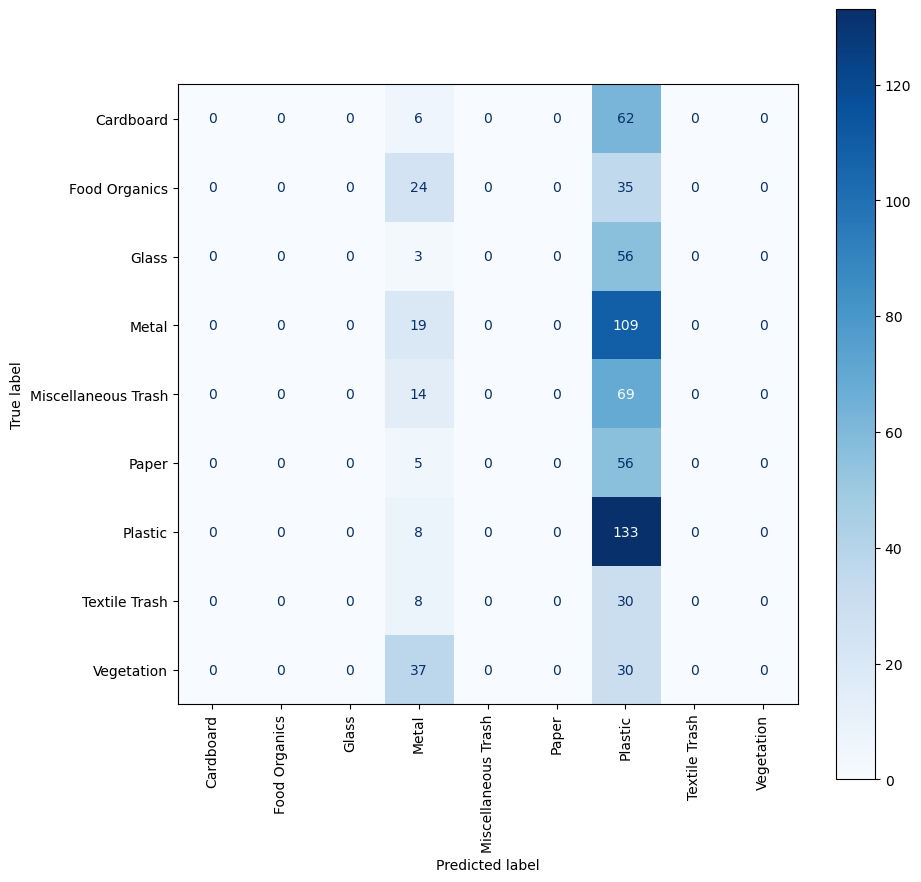

In [57]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

num_classes = len(class_names) 

y_true = []
y_pred = []

# collect predictions for the entire test set
for imgs, labels in test_dataset:
    preds = model2.predict(imgs, verbose=0)
    y_true.append(labels.numpy())
    y_pred.append(np.argmax(preds, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# build confusion matrix with all 9 classes
conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

# plot
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format="d")
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=10)
plt.show()


In [58]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = []
y_pred = []

for imgs, labels in test_dataset:
    preds = model2.predict(imgs, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision =", precision)
print("Recall =", recall)
print("F1 Score =", f1)


Precision = 0.07378645148650015
Recall = 0.2159090909090909
F1 Score = 0.10130824542232308


# CNN Model Architecture (`SGD(learning_rate=0.001,momentum=0.9)`)

In [43]:
from keras import Sequential
from keras.layers import Resizing, Rescaling, RandomRotation, RandomFlip , Dropout , RandomZoom , RandomTranslation , BatchNormalization
from keras.callbacks import ReduceLROnPlateau ,EarlyStopping

rescale_resize=Sequential([
    Rescaling(1.0/255),
    Resizing(128,128)
])

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.10),      
    RandomZoom(0.10),         
    RandomTranslation(0.10, 0.10), 
])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5, 
    restore_best_weights=True
)

In [44]:
from keras import layers
model3 = Sequential([
    rescale_resize,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)),

    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    Dropout(0.4),
    
    layers.Dense(256, activation='relu'),
    
    layers.Dense(9, activation='softmax'),
])

/home/himan/Desktop/pattern project/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
from keras.optimizers import SGD

model3.compile(optimizer=SGD(learning_rate=0.001,momentum=0.9),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [46]:
history = model3.fit(
    train_dataset,
    epochs=20,
    validation_data=cv_dataset,
    callbacks=[reduce_lr, early_stop],
)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.1827 - loss: 2.1599 - val_accuracy: 0.1986 - val_loss: 2.1382 - learning_rate: 0.0010
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1941 - loss: 2.1420 - val_accuracy: 0.1986 - val_loss: 2.1255 - learning_rate: 0.0010
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.2016 - loss: 2.1252 - val_accuracy: 0.2000 - val_loss: 2.1075 - learning_rate: 0.0010
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.2278 - loss: 2.0708 - val_accuracy: 0.2569 - val_loss: 2.0172 - learning_rate: 0.0010
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.2849 - loss: 1.9737 - val_accuracy: 0.3222 - val_loss: 1.9161 - learning_rate: 0.0010
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.3017 - loss: 1.9003 - val_accuracy: 0.3319 - val_loss: 1.8338 - learning_rate: 0.0010
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.3347 - loss: 1.

In [47]:
scores=model3.evaluate(test_dataset)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5398 - loss: 1.3146


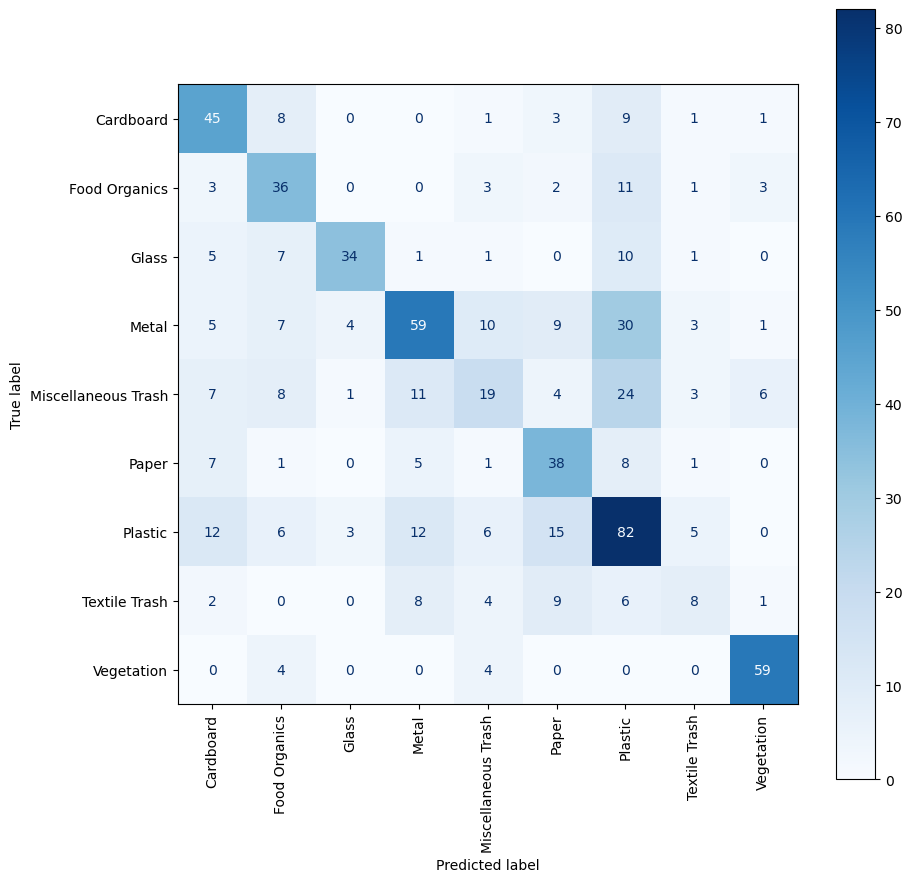

In [48]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

num_classes = len(class_names) 

y_true = []
y_pred = []

# collect predictions for the entire test set
for imgs, labels in test_dataset:
    preds = model3.predict(imgs, verbose=0)
    y_true.append(labels.numpy())
    y_pred.append(np.argmax(preds, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# build confusion matrix with all 9 classes
conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

# plot
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format="d")
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=10)
plt.show()


In [50]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = []
y_pred = []

for imgs, labels in test_dataset:
    preds = model3.predict(imgs, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision =", precision)
print("Recall =", recall)
print("F1 Score =", f1)


Precision = 0.5452838591007404
Recall = 0.5397727272727273
F1 Score = 0.5315265922536176


# Inception V3

In [3]:
from keras import applications
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator

## Loading and Preprocessing the Datasets for InceptionV3
This cell loads the pre-saved **TensorFlow datasets** for training, cross-validation and testing, then defines preprocessing steps specific to the **InceptionV3** architecture.

- The datasets are loaded from disk using `tf.data.Dataset.load()`, restoring previously saved TensorFlow `Dataset` objects.  
- Each image is resized to **524×524** because the **InceptionV3** model expects this.  
- The `preprocess_input()` scales image pixel values to the range **[-1, 1]**, as required by InceptionV3.  
- The preprocessing function returns processed `(image, label)` pairs and prepares the dataset for efficient GPU training.  


In [4]:
from keras.applications.inception_v3 import preprocess_input

AUTOTUNE = tf.data.AUTOTUNE
TARGET_SIZE = (524, 524)   

# Load the saved datasets
train_dataset = tf.data.Dataset.load("saved_datasets/train_dataset")
cv_dataset    = tf.data.Dataset.load("saved_datasets/cv_dataset")
test_dataset  = tf.data.Dataset.load("saved_datasets/test_dataset")

# Define preprocessing for InceptionV3
def preprocess(image, label):
    # Resize to 299x299
    image = tf.image.resize(image, TARGET_SIZE)
    # Apply InceptionV3 preprocessing (scales to [-1,1])
    image = preprocess_input(image)
    return image, label

print(train_dataset.element_spec) 

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [5]:
train_dataset = (train_dataset
                 .map(preprocess, num_parallel_calls=AUTOTUNE)
                 .shuffle(1000)
                 .prefetch(AUTOTUNE))

cv_dataset = (cv_dataset
              .map(preprocess, num_parallel_calls=AUTOTUNE)
              .prefetch(AUTOTUNE))

test_dataset = (test_dataset
                .map(preprocess, num_parallel_calls=AUTOTUNE)
                .prefetch(AUTOTUNE))

print(train_dataset.element_spec) 

(TensorSpec(shape=(None, 524, 524, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


## Model Architecture: Transfer Learning with InceptionV3

### Phase 1: Feature Extraction (Frozen Base Model)

**Base Model Configuration:**
- **Architecture**: InceptionV3 (pre-trained on ImageNet)
- **Top Layer**: Excluded (`include_top=False`) - we'll add custom classifier
- **Base Model Status**: Frozen (trainable=False) - weights won't update during initial training

**Custom Classification Head:**
1. **Input Layer**: (524, 524, 3)
2. **Preprocessing**: Rescaling layer (normalizes pixel values from [0, 255] to [0, 1])
3. **Base Model**: InceptionV3 feature extractor
4. **GlobalAveragePooling2D**: Reduces spatial dimensions, prevents overfitting
5. **Dense Layer**: 2048 units with ReLU activation - learns complex feature combinations
6. **Output Layer**: 9 units with softmax - multi-class classification (9 classes)

**Training Configuration:**
- **Loss Function**: Sparse Categorical Crossentropy
- **Optimizer**: Adam with learning rate = 0.001
- **Metrics**: Accuracy

**Training Strategy:**
- Train for **16 epochs** with frozen base to learn feature extraction
- Then unfreeze and fine-tune for **4 epochs** with lower learning rate

In [10]:
# 1. Create a base model with tf.keras.applications
tf.config.set_soft_device_placement(True)

#tf.debugging.set_log_device_placement(True)
base_model = tf.keras.applications.InceptionV3(include_top= False,)

#Freeze the base model
base_model.trainable = False

#Create inputs into models
inputs = tf.keras.layers.Input(shape =(524,524,3))

#Rescaling
x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

#Pass the inputs 
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

#DNN
x = layers.GlobalAveragePooling2D()(x)
print(f"GlobalAveragePooling2D: {x.shape}")

x = layers.Dense(units = 2048, activation = "relu")(x)

outputs = layers.Dense(9, activation = "softmax")(x)

model_InceptionV3 = tf.keras.Model(inputs, outputs)

#Compile the model
model_InceptionV3.compile(loss = "sparse_categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics = ["accuracy"])

Shape after passing inputs through base model: (None, 15, 15, 2048)
GlobalAveragePooling2D: (None, 2048)


In [11]:
history = model_InceptionV3.fit(train_dataset,
                                 epochs=16,
                                 validation_data = cv_dataset
                                )

Epoch 1/16
105/105 [==============================] - 115s 739ms/step - loss: 1.0376 - accuracy: 0.6327 - val_loss: 0.6772 - val_accuracy: 0.7776
Epoch 2/16
105/105 [==============================] - 84s 743ms/step - loss: 0.5144 - accuracy: 0.8190 - val_loss: 0.5354 - val_accuracy: 0.8096
Epoch 3/16
105/105 [==============================] - 84s 727ms/step - loss: 0.4288 - accuracy: 0.8408 - val_loss: 0.5011 - val_accuracy: 0.8328
Epoch 4/16
105/105 [==============================] - 63s 534ms/step - loss: 0.3257 - accuracy: 0.8818 - val_loss: 0.4487 - val_accuracy: 0.8241
Epoch 5/16
105/105 [==============================] - 64s 540ms/step - loss: 0.2670 - accuracy: 0.9012 - val_loss: 0.7864 - val_accuracy: 0.7326
Epoch 6/16
105/105 [==============================] - 63s 540ms/step - loss: 0.2317 - accuracy: 0.9164 - val_loss: 0.4028 - val_accuracy: 0.8648
Epoch 7/16
105/105 [==============================] - 62s 540ms/step - loss: 0.1801 - accuracy: 0.9384 - val_loss: 0.6699 - val_a

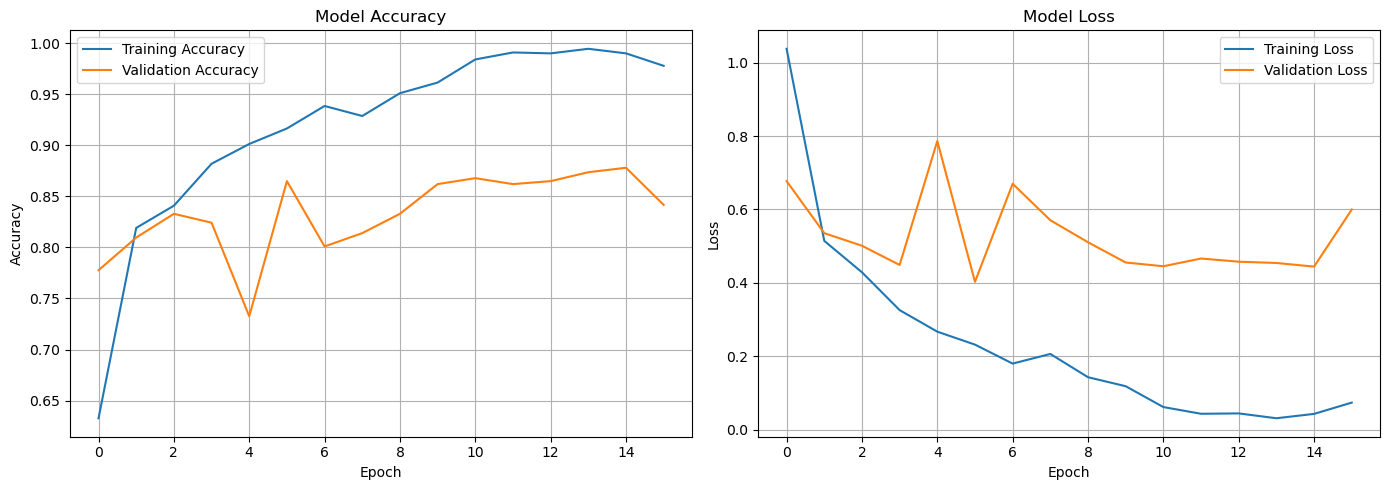


--------------------------------------------------
BASELINE MODEL PERFORMANCE
Final Training Accuracy: 0.9777
Final Validation Accuracy: 0.8416
Final Training Loss: 0.0738
Final Validation Loss: 0.5997
--------------------------------------------------


In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Final Performance
print("\n" + "-"*50)
print("BASELINE MODEL PERFORMANCE")
print("="*50)
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print("-"*50)

## Phase 2: Fine-Tuning by unfreezing layers

### Fine-Tuning Strategy

**Selective Layer Unfreezing:**
- **Base model trainable**: Set to `True` to allow weight updates
- **Layers unfrozen**: Last 10 layers of InceptionV3
- **Layers frozen**: All earlier layers remain frozen to preserve low-level features

```
Layer 0   ←─┐
Layer 1     │
Layer 2     │
...         ├─ These stay FROZEN
Layer 299   │
Layer 300   │
Layer 301 ──┘
Layer 302 ←─┐
Layer 303   │
Layer 304   │
...         ├─ These become TRAINABLE (last 10 layers)
Layer 308   │
Layer 309   │
Layer 310 ──┘
```

**Why unfreeze only the last 10 layers?**
- Early layers learn generic features so keep these frozen
- Later layers learn task-specific features because of that fine-tune these for our dataset
- Reduces risk of overfitting and catastrophic forgetting

**Why use a much smaller learning rate (1e-5) for fine-tuning?**
- Pre-trained weights are already optimized on millions of ImageNet images
- Large learning rates (0.001) cause catastrophic forgetting - destroying valuable features
- Small learning rates (1e-5) make gentle adjustments without breaking pre-trained knowledge
- Allows the model to adapt to your dataset while preserving general visual understanding

In [14]:
# To begin fine-tuning lets start by setting the last 10 layers as trainable
base_model.trainable = True

# Un-freeze last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to compile model every time there is a change)
model_InceptionV3.compile(loss = "sparse_categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5), 
                 metrics = ["accuracy"] )

## Verify Trainable Layers
Check which layers in the InceptionV3 base model are frozen vs trainable

In [15]:
# Check which layers are trainable
for layer_number, layer in enumerate(model_InceptionV3.layers[1].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 conv2d_96 False
2 batch_normalization_94 False
3 activation_94 False
4 conv2d_97 False
5 batch_normalization_95 False
6 activation_95 False
7 conv2d_98 False
8 batch_normalization_96 False
9 activation_96 False
10 max_pooling2d_6 False
11 conv2d_99 False
12 batch_normalization_97 False
13 activation_97 False
14 conv2d_100 False
15 batch_normalization_98 False
16 activation_98 False
17 max_pooling2d_7 False
18 conv2d_104 False
19 batch_normalization_102 False
20 activation_102 False
21 conv2d_102 False
22 conv2d_105 False
23 batch_normalization_100 False
24 batch_normalization_103 False
25 activation_100 False
26 activation_103 False
27 average_pooling2d_9 False
28 conv2d_101 False
29 conv2d_103 False
30 conv2d_106 False
31 conv2d_107 False
32 batch_normalization_99 False
33 batch_normalization_101 False
34 batch_normalization_104 False
35 batch_normalization_105 False
36 activation_99 False
37 activation_101 False
38 activation_104 False
39 activation_105 False
40 mix

In [16]:
# Now we have unfrozen some of the layers on the top 
print(len(model_InceptionV3.trainable_variables))

5


## Fine-Tuning Training
Continue training from epoch 16 for 4 additional epochs with unfrozen layers.

In [17]:
initial_epochs = 16
fine_tune_epochs = initial_epochs + 4

# Refit the model
history_2 = model_InceptionV3.fit(train_dataset,
                       epochs = fine_tune_epochs,
                       validation_data = cv_dataset,
                       initial_epoch = initial_epochs) 

Epoch 17/20
105/105 [==============================] - 68s 557ms/step - loss: 0.0435 - accuracy: 0.9881 - val_loss: 0.4748 - val_accuracy: 0.8765
Epoch 18/20
105/105 [==============================] - 61s 532ms/step - loss: 0.0242 - accuracy: 0.9958 - val_loss: 0.4641 - val_accuracy: 0.8721
Epoch 19/20
105/105 [==============================] - 61s 533ms/step - loss: 0.0200 - accuracy: 0.9967 - val_loss: 0.4625 - val_accuracy: 0.8779
Epoch 20/20
105/105 [==============================] - 61s 531ms/step - loss: 0.0171 - accuracy: 0.9979 - val_loss: 0.4598 - val_accuracy: 0.8779


In [18]:
model_InceptionV3.evaluate(test_dataset)

22/22 [==============================] - 11s 488ms/step - loss: 0.3977 - accuracy: 0.8864


[0.3977052569389343, 0.8863636255264282]

In [21]:
predictions=model_InceptionV3.predict(test_dataset)

predicted_class=np.zeros(32).astype(int)
for i in range(32):
    predicted_class[i]=np.argmax(predictions[i]).astype(int)


predicted_class_names=np.take(class_names, predicted_class)
print(predicted_class,class_names,predicted_class_names,sep='\n')

22/22 [==============================] - 11s 468ms/step
[6 5 5 4 5 6 6 1 2 5 5 1 0 3 5 6 3 3 4 1 6 5 2 3 3 2 8 6 2 3 3 0]
['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
['Plastic' 'Paper' 'Paper' 'Miscellaneous Trash' 'Paper' 'Plastic'
 'Plastic' 'Food Organics' 'Glass' 'Paper' 'Paper' 'Food Organics'
 'Cardboard' 'Metal' 'Paper' 'Plastic' 'Metal' 'Metal'
 'Miscellaneous Trash' 'Food Organics' 'Plastic' 'Paper' 'Glass' 'Metal'
 'Metal' 'Glass' 'Vegetation' 'Plastic' 'Glass' 'Metal' 'Metal'
 'Cardboard']


In [23]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay
for imges,labels in test_dataset.take(1):
    actual_class_names=np.take(class_names, labels.numpy())
    conf_matrix = confusion_matrix(actual_class_names, predicted_class_names)
conf_matrix

array([[2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 7, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 7, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 4, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int64)

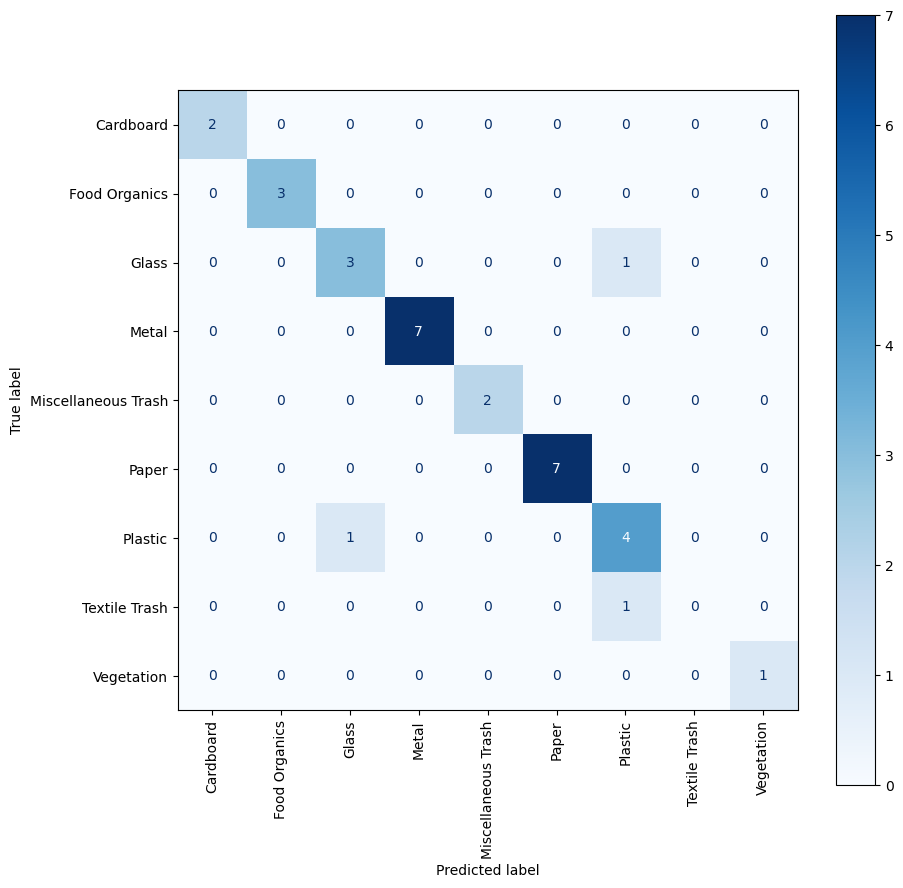

In [24]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format="d")
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=10)
plt.show()

In [25]:
precision = precision_score(actual_class_names, predicted_class_names,average='weighted')
recall = recall_score(actual_class_names, predicted_class_names,average='weighted')
f1score = f1_score(actual_class_names, predicted_class_names,average='weighted')
 
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")

Precision = 0.8854166666666666
Recall = 0.90625
F1 Score = 0.8948863636363636


c:\Users\VICTUS\Desktop\pattern project\env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# DesNet121

In [26]:
from keras.applications.densenet import DenseNet121
from keras.optimizers import Adam

## Model Architecture: Transfer Learning with DenseNet121

**Base Model Configuration:**
- **Architecture**: DenseNet121 (pre-trained on ImageNet)
- **Input shape**: (524, 524, 3)
- **Top layer**: Excluded - custom classifier added
- **Base model**: Frozen (all layers trainable=False)

**Custom Classification Head:**
- GlobalAveragePooling2D → Dense(2048, ReLU) → Dense(9, softmax)

**Training Strategy:**
- Train for 16 epochs with frozen base (lr=0.001)
- Fine-tune last layers for 4 epochs (lr=1e-5)

In [ ]:
base_model = DenseNet121(input_shape = (524, 524, 3),
                         include_top = False,
                         weights = 'imagenet'
                         )

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create model
model = Sequential()

# Add the pre-trained DenseNet-121 base model
model.add(base_model)

# Flatten the output of the base model
model.add(layers.GlobalAveragePooling2D())

# Add fully connected layers with dropout for regularization
model.add(layers.Dense(units = 2048, activation = "relu"))

model.add(layers.Dense(9, activation = "softmax"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 16, 16, 1024)      7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 2048)              2099200   
                                                                 
 dense_5 (Dense)             (None, 9)                 18441     
                                                                 
Total params: 9,155,145
Trainable params: 2,117,641
Non-trainable params: 7,037,504
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']            
)    

In [30]:
# Train the model 
history = model.fit(
    train_dataset,                                  
    epochs=16,                                        
    validation_data=cv_dataset,               
)

Epoch 1/16
105/105 [==============================] - 84s 688ms/step - loss: 0.9603 - accuracy: 0.6562 - val_loss: 0.6452 - val_accuracy: 0.7718
Epoch 2/16
105/105 [==============================] - 76s 656ms/step - loss: 0.5116 - accuracy: 0.8199 - val_loss: 0.7006 - val_accuracy: 0.7398
Epoch 3/16
105/105 [==============================] - 73s 646ms/step - loss: 0.3864 - accuracy: 0.8628 - val_loss: 0.5306 - val_accuracy: 0.8096
Epoch 4/16
105/105 [==============================] - 74s 657ms/step - loss: 0.3252 - accuracy: 0.8887 - val_loss: 0.4190 - val_accuracy: 0.8459
Epoch 5/16
105/105 [==============================] - 75s 652ms/step - loss: 0.2519 - accuracy: 0.9158 - val_loss: 0.4157 - val_accuracy: 0.8692
Epoch 6/16
105/105 [==============================] - 72s 637ms/step - loss: 0.2228 - accuracy: 0.9202 - val_loss: 0.4073 - val_accuracy: 0.8648
Epoch 7/16
105/105 [==============================] - 76s 657ms/step - loss: 0.1597 - accuracy: 0.9485 - val_loss: 0.3352 - val_ac

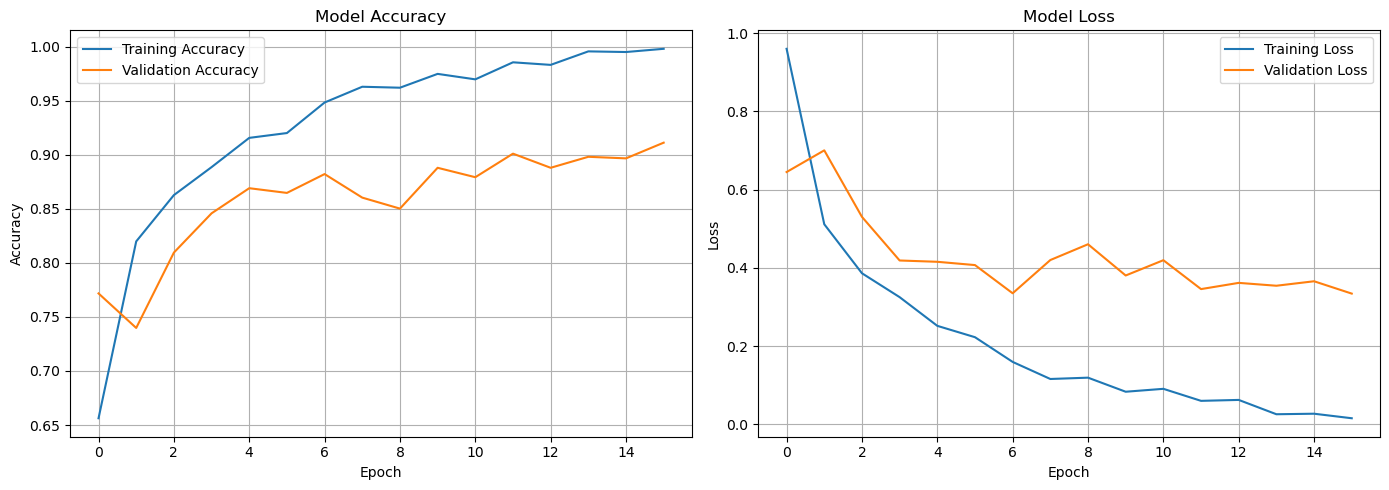


--------------------------------------------------
BASELINE MODEL PERFORMANCE
Final Training Accuracy: 0.9982
Final Validation Accuracy: 0.9113
Final Training Loss: 0.0156
Final Validation Loss: 0.3343
--------------------------------------------------


In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Final Performance
print("\n" + "-"*50)
print("BASELINE MODEL PERFORMANCE")
print("="*50)
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print("-"*50)

In [ ]:
# To begin fine-tuning lets start by setting the last 10 layers as trainable
base_model.trainable = True

# Un-freeze last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile 
model.compile(loss = "sparse_categorical_crossentropy",
                optimizer =  tf.keras.optimizers.Adam(learning_rate = 1e-5), 
                 metrics = ["accuracy"] )

In [34]:
initial_epochs = 16
fine_tune_epochs = initial_epochs + 4

# Refit the model
history_2 = model.fit(train_dataset,
                       epochs = fine_tune_epochs,
                       validation_data = cv_dataset,
                       initial_epoch =  initial_epochs) 

Epoch 17/20
105/105 [==============================] - 91s 700ms/step - loss: 0.9381 - accuracy: 0.8089 - val_loss: 0.4812 - val_accuracy: 0.8794
Epoch 18/20
105/105 [==============================] - 76s 660ms/step - loss: 0.2744 - accuracy: 0.9182 - val_loss: 0.5818 - val_accuracy: 0.8677
Epoch 19/20
105/105 [==============================] - 75s 662ms/step - loss: 0.1351 - accuracy: 0.9542 - val_loss: 0.6167 - val_accuracy: 0.8663
Epoch 20/20
105/105 [==============================] - 74s 656ms/step - loss: 0.0890 - accuracy: 0.9688 - val_loss: 0.6234 - val_accuracy: 0.8735


In [35]:
model.evaluate(test_dataset)

22/22 [==============================] - 13s 581ms/step - loss: 0.5672 - accuracy: 0.8849


[0.5672264099121094, 0.8849431872367859]

In [36]:
predictions=model.predict(test_dataset)

predicted_class=np.zeros(32).astype(int)
for i in range(32):
    predicted_class[i]=np.argmax(predictions[i]).astype(int)


predicted_class_names=np.take(class_names, predicted_class)
print(predicted_class,class_names,predicted_class_names,sep='\n')

22/22 [==============================] - 14s 536ms/step
[6 5 5 4 5 6 6 1 2 5 5 1 3 3 5 7 3 3 4 1 6 5 2 3 3 2 8 2 2 3 3 0]
['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
['Plastic' 'Paper' 'Paper' 'Miscellaneous Trash' 'Paper' 'Plastic'
 'Plastic' 'Food Organics' 'Glass' 'Paper' 'Paper' 'Food Organics' 'Metal'
 'Metal' 'Paper' 'Textile Trash' 'Metal' 'Metal' 'Miscellaneous Trash'
 'Food Organics' 'Plastic' 'Paper' 'Glass' 'Metal' 'Metal' 'Glass'
 'Vegetation' 'Glass' 'Glass' 'Metal' 'Metal' 'Cardboard']


In [ ]:
#calculating the confusion matrix
for imges,labels in test_dataset.take(1):
    actual_class_names=np.take(class_names, labels.numpy())
    conf_matrix = confusion_matrix(actual_class_names, predicted_class_names)
conf_matrix

array([[1, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 4, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 7, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 7, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 4, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int64)

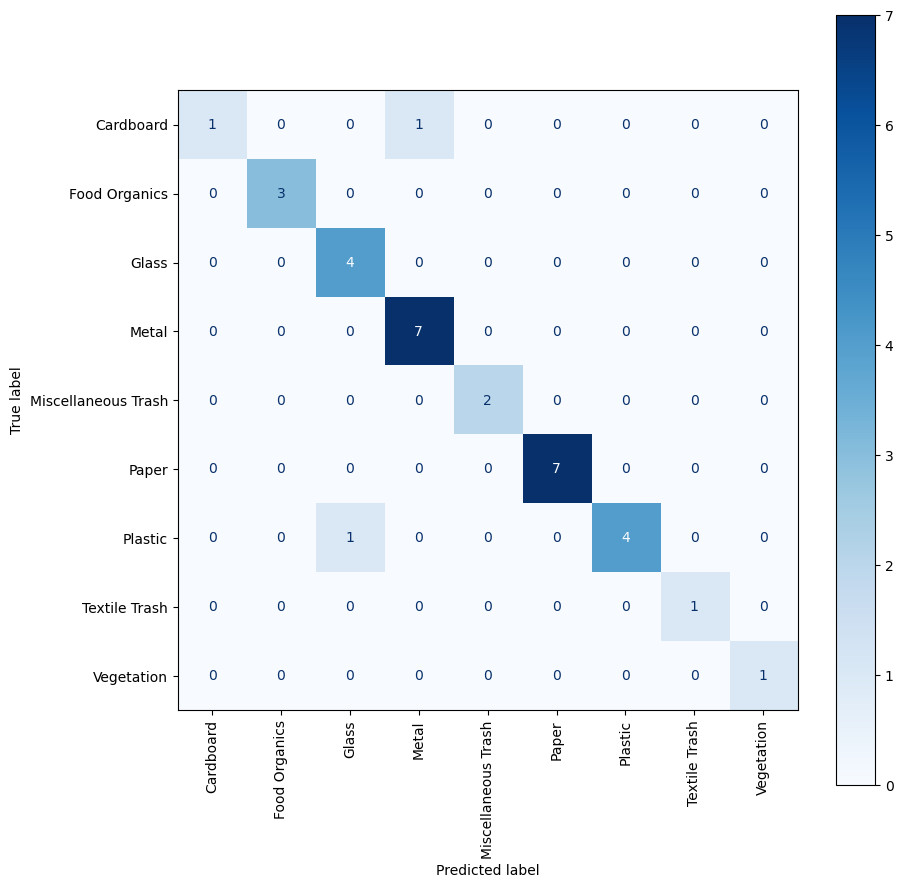

In [38]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format="d")
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=10)
plt.show()

In [ ]:
#classification matrix for desnet 121
precision = precision_score(actual_class_names, predicted_class_names,average='weighted')
recall = recall_score(actual_class_names, predicted_class_names,average='weighted')
f1score = f1_score(actual_class_names, predicted_class_names,average='weighted')
 
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")

Precision = 0.94765625
Recall = 0.9375
F1 Score = 0.9333333333333333
